## Introduction

<p>
<img src="https://i.imgur.com/Kuh9gPj.png" width="450" align="right"/>
<br/>
You are an urban safety planner in Japan, and you are analyzing which areas of Japan need extra earthquake reinforcement.

You need to answer which areas are both high in population density and prone to earthquakes?
</p>

Before you get started, run the code cell below to set everything up.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import folium
from folium import Choropleth
from folium.plugins import HeatMap

Let's define a function `embed_map()` for displaying interactive maps in a way such that they are visible in all web browsers. It accepts two arguments:
- the variable containing the map,
- the name of the HTML file where the map will be saved.

In [2]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## Exercises

### 1) Do earthquakes coincide with plate boundaries?

Run the code cell below to create a DataFrame `plate_boundaries` that shows global plate boundaries. 

The **coordinates** column is a list of (latitude, longitude) locations along the boundaries.

In [3]:
plate_boundaries = gpd.read_file("../input//Plate_Boundaries/Plate_Boundaries.shp")
plate_boundaries['coordinates'] = plate_boundaries.apply(lambda x: [(b,a) for (a,b) in list(x.geometry.coords)], axis='columns')
plate_boundaries.drop('geometry', axis=1, inplace=True)

plate_boundaries.head(3)

,HAZ_PLATES,HAZ_PLAT_1,HAZ_PLAT_2,Shape_Leng,coordinates
0,TRENCH,SERAM TROUGH (ACTIVE),6722,5.843467,"[(-5.444200361999947, 133.6808931800001), (-5...."
1,TRENCH,WETAR THRUST,6722,1.829013,"[(-7.760600482999962, 125.47879802900002), (-7..."
2,TRENCH,TRENCH WEST OF LUZON (MANILA TRENCH) NORTHERN ...,6621,6.743604,"[(19.817899819000047, 120.09999798800004), (19..."


Next, run the code cell below without changes to load the historical earthquake data into a DataFrame earthquakes.

In [4]:
# Load the data and print the first 5 rows
earthquakes = pd.read_csv("../input/earthquakes1970-2014.csv", parse_dates=["DateTime"])
earthquakes.head(3)

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,1970-01-04 17:00:40.200,24.139,102.503,31.0,7.5,Ms,90.0,NaN,NaN,0.0,NEI,1.970010e+09
1,1970-01-06 05:35:51.800,-9.628,151.458,8.0,6.2,Ms,85.0,NaN,NaN,0.0,NEI,1.970011e+09
2,1970-01-08 17:12:39.100,-34.741,178.568,179.0,6.1,Mb,59.0,NaN,NaN,0.0,NEI,1.970011e+09


The code cell below visualizes the plate boundaries on a map. Use all of the earthquake data to add a heatmap to the same map, to determine whether earthquakes coincide with plate boundaries. 

In [5]:
# Create a base map with plate boundaries
m_1 = folium.Map(location=[36.5,136], tiles='cartodbpositron', zoom_start=5)
for i in range(len(plate_boundaries)):
    folium.PolyLine(locations=plate_boundaries.coordinates.iloc[i], weight=2, color='black').add_to(m_1)

# Your code here: Add a heatmap to the map
HeatMap(data=earthquakes[['Latitude', 'Longitude']], radius=15).add_to(m_1)

# Show the map
embed_map(m_1, 'q_1.html')

### 2) Is there a relationship between earthquake depth and proximity to a plate boundary in Japan?

You recently read that the depth of earthquakes tells us [important information](https://www.usgs.gov/faqs/what-depth-do-earthquakes-occur-what-significance-depth?qt-news_science_products=0#qt-news_science_products) about the structure of the earth.  You're interested to see if there are any intereresting global patterns, and you'd also like to understand how depth varies in Japan.

In [6]:
depth_limits = earthquakes.Depth.agg(['min','max'])
depth_limits

min      0.0
max    688.0
Name: Depth, dtype: float64

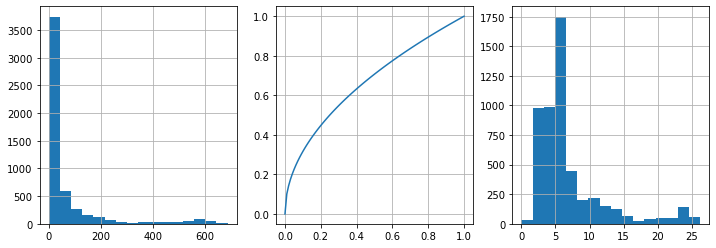

In [9]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(12,4))
ax0.hist(earthquakes.Depth, bins=16)
ax0.grid()

x = np.linspace(0, 1, 100)
ax1.plot(x, np.sqrt(x))
ax1.grid()

ax2.hist(earthquakes.Depth.apply(lambda x: np.sqrt(x)), bins=16)
ax2.grid(True)

plt.show()

We need to create a color encoder to assigna a color based on the Depth value of the earthquake

In [10]:
from matplotlib import cm, colors

class ColorEncoder:
    
    def __init__(self, min_value=0, max_value=1000, cmap='viridis', mapper=lambda x: x):
        self.cmap= cm.get_cmap(cmap, 256)
        self.mapper = mapper
        self.norm = colors.Normalize(vmin=min_value,
                                     vmax=max_value)
    def __call__(self, x):
        return colors.to_hex(self.cmap(self.mapper(self.norm(x))))
        
color_encoder = ColorEncoder(0, depth_limits['max'], cmap='viridis', mapper=lambda x: np.sqrt(x))

print(color_encoder(10))
print(color_encoder(700))

#472a7a
#fde725


In [11]:
# Create a base map with plate boundaries
m_2 = folium.Map(location=[36, 136], tiles='cartodbpositron', zoom_start=5)

# Creaate and add polylines representing plate boundaries
for i in range(len(plate_boundaries)):
    folium.PolyLine(locations=plate_boundaries.coordinates.iloc[i], weight=2, color='black').add_to(m_2)

# Your code here: 
# Add a map to visualize earthquake depth
for idx, row in earthquakes.iterrows():
    folium.Circle(location=[row.Latitude, row.Longitude], 
                  radius=2000, color=color_encoder(row.Depth)).add_to(m_2)

# View the map
embed_map(m_2, 'q_2.html')

Can you detect a relationship between proximity to a plate boundary and earthquake depth? Does this pattern hold globally? In Japan?

> **Answer:** In the northern half of Japan, it does appear that earthquakes closer to plate boundaries tend to be shallower, and earthquakes farther from plate boundaries are deeper. This pattern is repeated in other locations, such as the western coast of South America. But, it does not hold everywhere (for instance, in China, Mongolia, and Russia).

### 3) Which prefectures have high population density?

Run the next code cell (without changes) to create a GeoDataFrame prefectures that contains the geographical boundaries of Japanese prefectures.

In [12]:
# GeoDataFrame with prefecture boundaries
prefectures = gpd.read_file("../input/japan-prefecture-boundaries/japan-prefecture-boundaries.shp")
prefectures.set_index('prefecture', inplace=True)
prefectures.head()

,geometry
prefecture,
Aichi,"MULTIPOLYGON (((137.09523 34.65330, 137.09546 ..."
Akita,"MULTIPOLYGON (((139.55725 39.20330, 139.55765 ..."
Aomori,"MULTIPOLYGON (((141.39860 40.92472, 141.39806 ..."
Chiba,"MULTIPOLYGON (((139.82488 34.98967, 139.82434 ..."
Ehime,"MULTIPOLYGON (((132.55859 32.91224, 132.55904 ..."


The next code cell creates a DataFrame stats containing the population, area (in square kilometers), and population density (per square kilometer) for each Japanese prefecture. Run the code cell without changes:

In [13]:
# DataFrame containing population of each prefecture
population = pd.read_csv("../input/japan-prefecture-population.csv")
population.set_index('prefecture', inplace=True)

# Calculate area (in square kilometers) of each prefecture
area_sqkm = pd.Series(prefectures.geometry.to_crs(epsg=32654).area / 10**6, name='area_sqkm')
stats = population.join(area_sqkm)

# Add density (per square kilometer) of each prefecture
stats['density'] = stats["population"] / stats["area_sqkm"]
stats.head()

,population,area_sqkm,density
prefecture,,,
Tokyo,12868000,1800.614782,7146.448049
Kanagawa,8943000,2383.038975,3752.771186
Osaka,8801000,1923.151529,4576.342460
Aichi,7418000,5164.400005,1436.372085
Saitama,7130000,3794.036890,1879.264806


Use the next code cell to create a choropleth map to visualize population density per prefecture.

In [18]:
# Create a base map
m_3 = folium.Map(location=[35,136], tiles='cartodbpositron', zoom_start=6)

# Your code here: create a choropleth map to visualize population density
Choropleth(geo_data=prefectures.__geo_interface__, data=stats['density'], 
           key_on="feature.id", fill_color='YlGnBu', 
           legend_name='Population Density'
          ).add_to(m_3)

# View the map
embed_map(m_3, 'q_3.html')

Which three prefectures have relatively higher density than the others?  Are they spread throughout the country, or all located in roughly the same geographical region? (*If you're unfamiliar with Japanese geography, you might find [this map](https://en.wikipedia.org/wiki/Prefectures_of_Japan) useful to answer the questions.*)

> **Answer:** Tokyo, Kanagawa, and Osaka have the highest population density. All of these prefectures are located in central Japan, and Tokyo and Kanagawa are adjacent.

### 4) Which high-density prefecture is prone to high-magnitude earthquakes?

Create a map to suggest one prefecture that might benefit from earthquake reinforcement. Your map should visualize both density and earthquake magnitude.

In [15]:
# filter for eartquakes in Japan
ek_filter = ((earthquakes.Latitude > 30) & (earthquakes.Latitude < 50) &
             (earthquakes.Longitude > 120) & (earthquakes.Longitude < 150))

earthquakes[ek_filter]['Magnitude'].agg(['min', 'max'])

min    6.0
max    9.1
Name: Magnitude, dtype: float64

In [17]:
# Create a base map
m_4 = folium.Map(location=[35,136], tiles='cartodbpositron', zoom_start=6)

# Your code here: create a map

def color_magnitud(val):
    if val < 6.5:
        return 'gold'
    if val < 7:
        return 'darkorange'
    elif val < 7.5:
        return 'red'
    elif val < 8:
        return 'darkred'
    elif val < 8.5:
        return 'purple'
    else:
        return 'indigo'

# create a choropleth map to visualize population density
Choropleth(geo_data=prefectures.__geo_interface__, data=stats['density'], 
           key_on="feature.id", fill_color='YlGnBu', 
           legend_name='Population Density'
          ).add_to(m_4)

# visualize earthquake magnitudes by color
for idx, row in earthquakes[ek_filter].iterrows():
    folium.Circle(location=[row.Latitude, row.Longitude], radius=2000, color=color_magnitud(row.Magnitude)).add_to(m_4)

# View the map
embed_map(m_4, 'q_4.html')

Which prefecture do you recommend for extra earthquake reinforcement?

> **Anser:** While there's no clear, single answer to this question, there are a few reasonable options:
- Tokyo is by far the most densely populated prefecture and has also experienced a number of earthquakes. 
- Osaka is relatively less densely populated, but experienced an earthquake that was relatively stronger than those near Tokyo. 
- And, the long coast of Kanagawa (in addition to its high density and the historical proximity of strong earthquakes) might lead us to worry about the added potential tsunami risk.